# Intel MPI Benchmarks

Results of selected MPI1 tests from the [IMB benchmark suite](https://software.intel.com/content/www/us/en/develop/documentation/imb-user-guide/top.html).

All tests use two nodes:
- pingpong: Single process per node
- uniband: Multiple processes per node, communicating in pairs split across nodes
- biband: As for uniband but communication initiated in both directions
- alltoall: As many processes on each node as there are (hardware) cores

Tests use a range of message sizes and report bandwidth and/or latency.

In [4]:
# Plotting setup
%matplotlib inline
import matplotlib.pyplot as plt
from matplotlib import ticker
from IPython.display import display, Markdown

import pandas as pd
import os, sys
from pprint import pprint
sys.path.extend(('../../reframe', '../../')) # the `modules` package imports `reframe` so need that in sys.modules
import modules

# Bandwidth/latency vs message size

The plots below show results vs message size for selected tests:
- pingpong
- 2x process runs of uniband and biband
- alltoall (using all cores on each node)

Results are for the most-recent test on each system/partition/environment combination.

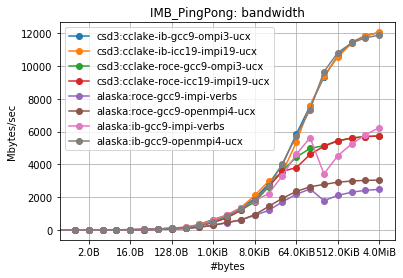

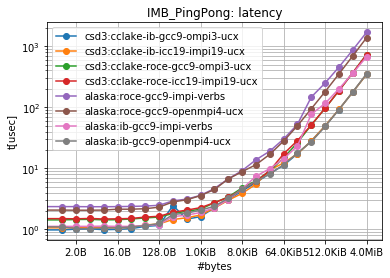

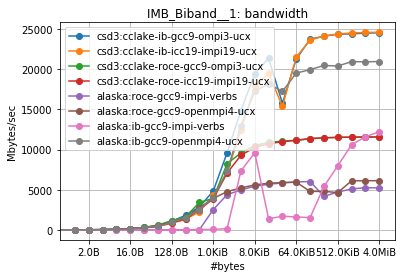

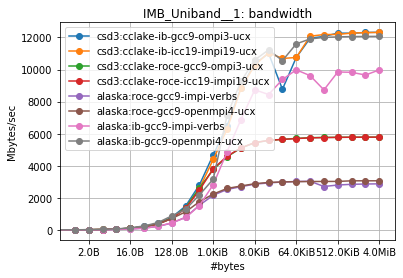

In [6]:
for (test, column, param) in [('IMB_PingPong', 'Mbytes/sec', 'bandwidth'),
                              ('IMB_PingPong', 't[usec]', 'latency'),
                              ('IMB_Biband__1', 'Mbytes/sec', 'bandwidth'),
                              ('IMB_Uniband__1', 'Mbytes/sec', 'bandwidth'),
                             ]:
    
    # find all data and work out differences between them:
    paths = modules.utils.find_run_outputs(root='../../output', test=test)
    fig, ax = plt.subplots(nrows=1, ncols=1)
    meta = [modules.utils.parse_path_metadata(p) for p in paths]
    
    # load and plot:
    for ix, path in enumerate(paths):
        datas = modules.imb.read_imb_out(path)
        assert len(datas) == 1
        data = datas[list(datas.keys())[0]]
        label = '%s:%s' % (meta[ix]['sysname'], meta[ix]['partition'])
        plt.plot(data['#bytes'], data[column], 'o-', data=data, label=label)
        
    # format plot:
    ax.set_xscale('log', basex=2)
    if param == 'latency':
        ax.set_yscale('log', basey=10)
    ax.xaxis.set_major_formatter(ticker.FuncFormatter(lambda x, pos: modules.utils.sizeof_fmt(x)))
    ax.grid(True, which="both")
    ax.set_xlabel('#bytes')
    ax.set_ylabel(column)
    ax.set_title('%s: %s' % (test, param))
    ax.legend()

# Max Bandwidth vs Number of Processes per Node

The plots below show the **maximum** bandwidth for tests using varying numbers of processes per node. Results are for the most-recent test on each system/partition/environment combination.

### IMB_Uniband_*: Max bandwidth (MB)

case,alaska:ib-gcc9-impi-verbs,alaska:ib-gcc9-openmpi4-ucx,alaska:roce-gcc9-impi-verbs,alaska:roce-gcc9-openmpi4-ucx,csd3:cclake-ib-gcc9-ompi3-ucx,csd3:cclake-ib-icc19-impi19-ucx,csd3:cclake-roce-gcc9-ompi3-ucx,csd3:cclake-roce-icc19-impi19-ucx
procs_per_node,,,,,,,,
1,9982.30,12069.41,3035.53,3063.07,12326.18,12315.11,5784.96,5785.37
2,11969.46,12391.68,3055.31,3063.49,12342.85,12343.63,5786.22,5786.33
4,12359.13,12073.87,3057.86,3063.51,NaN,NaN,NaN,NaN
8,12374.42,12392.29,3061.50,3063.50,NaN,NaN,NaN,NaN
14,NaN,NaN,NaN,NaN,12345.46,12345.29,5786.28,5786.31
16,12378.69,12392.62,3061.91,3063.49,NaN,NaN,NaN,NaN
24,12380.10,12392.77,3061.74,3063.49,NaN,NaN,NaN,NaN
28,NaN,NaN,NaN,NaN,12297.48,12345.31,5786.26,5786.19
32,12377.54,12050.35,3061.74,3063.49,NaN,NaN,NaN,NaN


### IMB_Uniband_*: Max bandwidth as % of theoretical bandwidth

case,alaska:ib-gcc9-impi-verbs,alaska:ib-gcc9-openmpi4-ucx,alaska:roce-gcc9-impi-verbs,alaska:roce-gcc9-openmpi4-ucx,csd3:cclake-ib-gcc9-ompi3-ucx,csd3:cclake-ib-icc19-impi19-ucx,csd3:cclake-roce-gcc9-ompi3-ucx,csd3:cclake-roce-icc19-impi19-ucx
procs_per_node,,,,,,,,
1,79,96,97,98,98,98,92,92
2,95,99,97,98,98,98,92,92
4,98,96,97,98,0,0,0,0
8,98,99,97,98,0,0,0,0
14,0,0,0,0,98,98,92,92
16,99,99,97,98,0,0,0,0
24,99,99,97,98,0,0,0,0
28,0,0,0,0,98,98,92,92
32,99,96,97,98,0,0,0,0


### IMB_Biband_*: Max bandwidth (MB)

case,alaska:ib-gcc9-impi-verbs,alaska:ib-gcc9-openmpi4-ucx,alaska:roce-gcc9-impi-verbs,alaska:roce-gcc9-openmpi4-ucx,csd3:cclake-ib-gcc9-ompi3-ucx,csd3:cclake-ib-icc19-impi19-ucx,csd3:cclake-roce-gcc9-ompi3-ucx,csd3:cclake-roce-icc19-impi19-ucx
procs_per_node,,,,,,,,
1,12218.07,12405.48,6018.67,6124.72,24532.56,24600.40,11565.58,11566.42
2,18306.47,20656.38,6088.25,6126.33,24637.37,24630.22,11569.97,11570.88
4,20091.47,20545.70,6104.28,6125.74,NaN,NaN,NaN,NaN
8,20438.51,20484.15,6117.38,6125.56,NaN,NaN,NaN,NaN
14,NaN,NaN,NaN,NaN,24641.35,24644.66,11570.36,11571.68
16,20483.31,20721.47,6119.47,6126.57,NaN,NaN,NaN,NaN
24,20656.06,20537.13,6114.86,6126.47,NaN,NaN,NaN,NaN
28,NaN,NaN,NaN,NaN,24603.13,24630.87,11569.60,11571.29
32,20508.70,20694.43,6116.82,6126.48,NaN,NaN,NaN,NaN


### IMB_Biband_*: Max bandwidth as % of theoretical bandwidth

case,alaska:ib-gcc9-impi-verbs,alaska:ib-gcc9-openmpi4-ucx,alaska:roce-gcc9-impi-verbs,alaska:roce-gcc9-openmpi4-ucx,csd3:cclake-ib-gcc9-ompi3-ucx,csd3:cclake-ib-icc19-impi19-ucx,csd3:cclake-roce-gcc9-ompi3-ucx,csd3:cclake-roce-icc19-impi19-ucx
procs_per_node,,,,,,,,
1,48,49,96,97,98,98,92,92
2,73,82,97,98,98,98,92,92
4,80,82,97,98,0,0,0,0
8,81,81,97,98,0,0,0,0
14,0,0,0,0,98,98,92,92
16,81,82,97,98,0,0,0,0
24,82,82,97,98,0,0,0,0
28,0,0,0,0,98,98,92,92
32,82,82,97,98,0,0,0,0


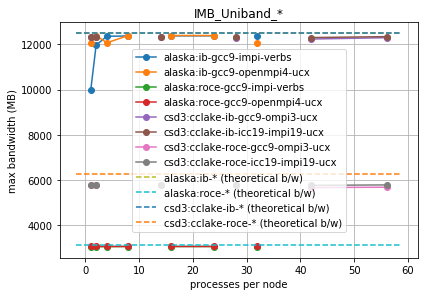

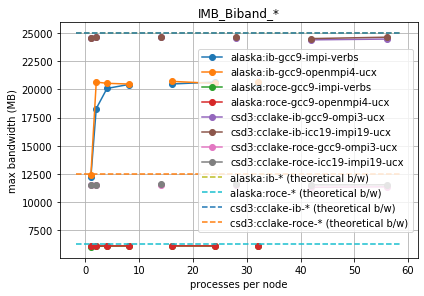

In [9]:
# constants:
Gb_to_MB = 125.0
TEST_BANDWIDTH_FACTOR = {'IMB_Uniband_*':1.0, 'IMB_Biband_*':2.0} # b/c biband is bidirectional

for test in ['IMB_Uniband_*', 'IMB_Biband_*']:
    
    # get, plot and tabulate data:
    df = modules.utils.tabulate_last_perf(test, 'procs_per_node', 'max_bandwidth')
    display(Markdown('### %s: Max bandwidth (MB)' % test))
    display(df)
    ax = df.plot(grid=True, style='o-')
    
    # add max bandwidth info to plot:
    xlim = ax.get_xlim()
    for syspart, bw in modules.utils.get_sys_param('interconnect_Gb').items():
        theoretical_bw_MB = bw * Gb_to_MB * TEST_BANDWIDTH_FACTOR[test]
        label = syspart + " (theoretical b/w)"
        ax.plot(xlim, [theoretical_bw_MB, theoretical_bw_MB], '--', label=label)
    
    # format plot:
    ax.set_xlabel('processes per node')
    ax.set_ylabel('max bandwidth (MB)')
    plt.tight_layout()
    ax.set_title(test)
    ax.legend()
    
    # TODO: calculate real vs theortical perf
    display(Markdown('### %s: Max bandwidth as %% of theoretical bandwidth' % test))
    theory = [modules.utils.get_sysinfo(syspart)['interconnect_Gb'] * Gb_to_MB * TEST_BANDWIDTH_FACTOR[test] for syspart in df.columns]
    df_percent = 100 * (df / theory)
    display(df_percent.fillna(0).astype(int))
    
